Example 2: Detecting Circular Permutations
============================================

In [1]:
import os
import numpy as np

from GWProt import GW_protein, stress_comparison, switch_probabilities, pymol_protein_viewer


Riboviruses are a realm of viruses which include many human pathogens. They all have an essential RNA-dependent RNA-polymerase (RdRp) which is key to their replication machinery, has a high mutation rate, and often very low sequence homology; thus structural comparison can be key to identification and classification.

Viral RdRps contain some [circularly permuted proteins](https://en.wikipedia.org/wiki/Circular_permutation_in_proteins) across multiple phyla - proteins where the same motifs or domains appear in different orders along the backbone. RdRps contain three active site motifs labelled A, B and C which typically appear in the order ABC but can also appear in the order CAB. We use 'ABC' and 'CAB' to denote these two different types of RdRps.

![Example_Data/Images/ABC_Regions.PNG](Example_Data/Images/ABC_Regions.PNG)

We first load 10 proteins of each type, whose PDB files were predicted using AlphaFold.

In [2]:
dir = '../Examples/Example_Data/Circularly Permuted Proteins/'
file_list = os.listdir(dir)
ABC_prots = [GW_protein.GW_protein.make_protein_from_pdb(os.path.join(dir , file)) for file in file_list[:10]]
CAB_prots = [GW_protein.GW_protein.make_protein_from_pdb(os.path.join(dir , file)) for file in file_list[10:]]

We then create a `stress_comparison.Stress_Comparison` object and run GW all-vs-all in it.

In [3]:
A = stress_comparison.Stress_Comparison(prot_list=ABC_prots + CAB_prots)
A.GW_compute_stresses()

Using UMAP visualization, we see that we can cluster the proteins by permutation type using GW distance; however this is very weak.

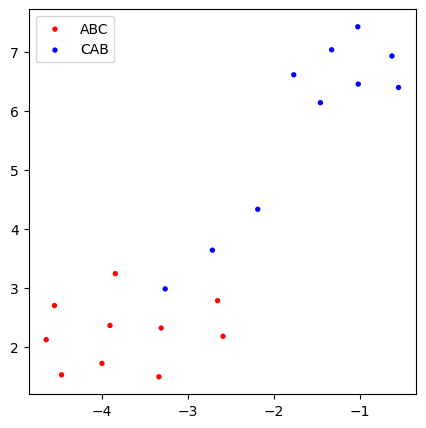

In [4]:
import matplotlib.pyplot as plt
from umap.umap_ import UMAP
reducer = UMAP(metric = 'precomputed')
embedding = reducer.fit_transform(A.get_GW_dmat())
plt.figure(figsize=(5,5)) 
plt.scatter(embedding[:10,0] ,embedding[:10,1], color = ['red']*10 , s = 8 )
plt.scatter(embedding[10:,0] ,embedding[10:,1], color = ['blue']*10 , s = 8 )
plt.legend(["ABC","CAB" ])

If we look at the transport plan between two ABC proteins or two CAB proteins, we see that it is very similar to the identity matrix, meaning that the alignment given by GW is nearly just the sequential alignment.

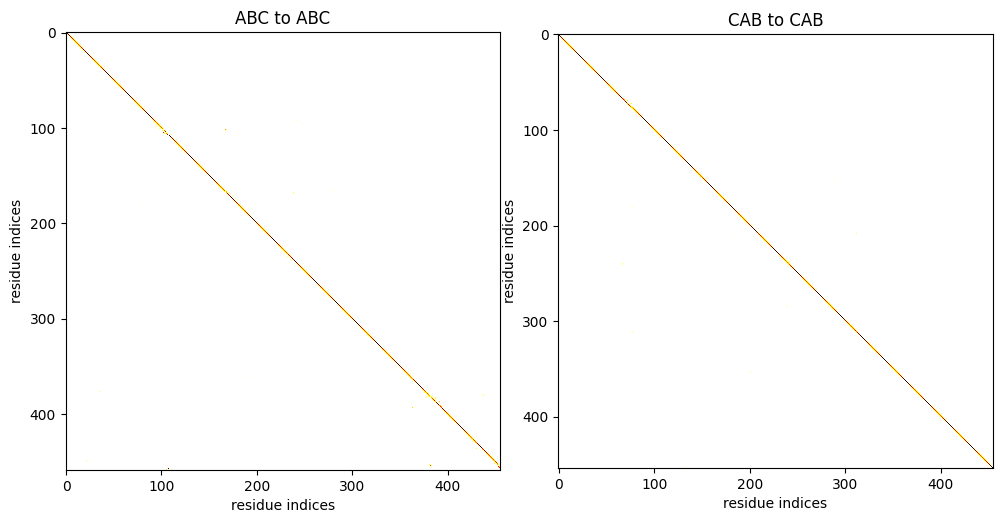

In [5]:

fig , axes = plt.subplots(nrows = 1, ncols = 2, figsize=(10,10))
fig.tight_layout()

# two ABC proteins
axes[0].imshow(A.transport_dict[A.name_list[0]][A.name_list[1]], cmap = 'hot_r')
axes[0].set_title('ABC to ABC')
axes[0].set_xlabel('residue indices')
axes[0].set_ylabel('residue indices')


#two CAB proteins
axes[1].imshow(A.transport_dict[A.name_list[10]][A.name_list[11]], cmap = 'hot_r')
axes[1].set_title('CAB to CAB')
axes[1].set_xlabel('residue indices')
axes[1].set_ylabel('residue indices')
plt.show()



In contrast if we look at the transport plan between an ABC protein and a CAB protein it is close to being the identity matrix aside from a small section where the C regions are aligned.

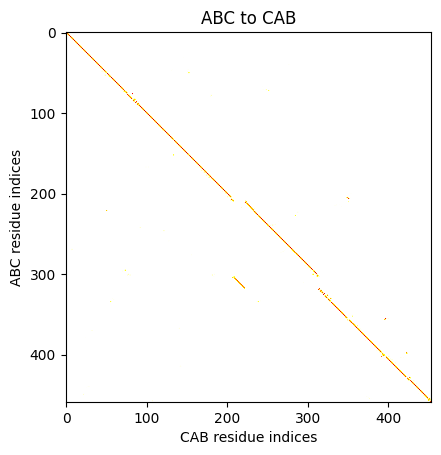

In [6]:
plt.imshow(A.transport_dict[A.name_list[0]][A.name_list[10]], cmap = 'hot_r', label = 'ABC to CAB')
plt.title('ABC to CAB')
plt.xlabel('CAB residue indices')
plt.ylabel('ABC residue indices')
plt.show()

In pymol we can visualized the transport plan. `pymol_protein_viewer.compare_proteins_in_pymol` uses `weighted_alignment.weighted_RMSD` to superimpose the two proteins minimizign weighted RMSD. `compare_proteins_in_pymol` allows displays dashes between pairs of aligned residues.

In [7]:
pymol_protein_viewer.compare_proteins_in_pymol(
    file1 = dir + file_list[0], 
    file2 = dir + file_list[10],
    chain1 ='A', 
    chain2 ='A', 
    transport_plan=A.transport_dict[A.name_list[0]][A.name_list[10]], 
    output_file= 'Example_Data/Pymol Outputs/Circular Permutations.pse') 

In this screenshot we see the two proteins overlaid. The ABC protein is in green and the CAB protein in blue, the redder sections indicate areas with higher stress levels. The transport plan is shown by the yellow lines between paired residues.

![Example_Data/Images/RdRp_ABC_CAB.PNG](Example_Data/Images/RdRp_ABC_CAB.PNG)

We can use `switch_probabilities.get_switch_prob` to see which residues are switched and  `switch_probabilities.visualize_switch_probabibilities` for visualization.


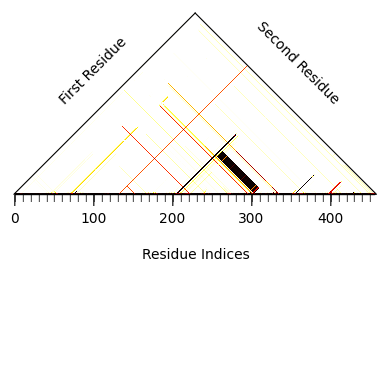

In [8]:
switch_probabilities.visualize_switch_probabibilities(switch_probabilities.get_switch_probabilities(A.transport_dict[A.name_list[0]][A.name_list[10]], prot_num=0))

The white and light-colored areas represent pairs of residues whose orders are preserved and the dark rectangles are pairs whose orders are switched. `prot_num = 0` means these are the residues of the 0th protein of these two, `A.prot_list[0]` which is an ABC protein. From the largest dark rectangle in the plot we can see that residues 211-303 switch with residues 305-318. Indeed these include the region from A to B and C respectively. 

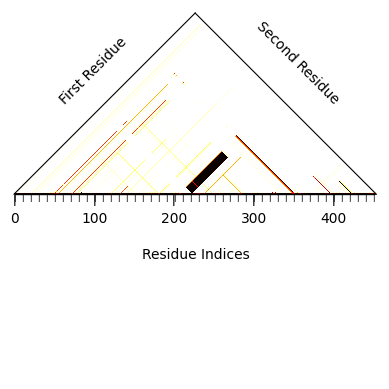

In [9]:
switch_probabilities.visualize_switch_probabibilities(switch_probabilities.get_switch_probabilities(A.transport_dict[A.name_list[0]][A.name_list[10]], prot_num=1))

The white and light-colored areas represent pairs of residues whose orders are preserved and the dark rectangles are pairs whose orders are switched. `prot_num = 1` means these are the residues of the 1st protein of these two, `A.prot_list[10]` which is a CAB protein. From the plot we can see that residues 209-222 switch with residues 224-313. Indeed these include the C region and region from A to B  respectively.

Using `switch_probabilities.preprocess` and `switch_probabilities.max_rectangle_diagonal` we can find the size of the largest such rectangle for each pair of proteins. This can indicate whether two proteins have the same or different permutation types.


In [11]:
switch_score_mat = np.zeros((20,20))

for i in range(20):
    for j in range(20):
        if i ==j:
            continue

        T = A.transport_dict[A.name_list[i]][A.name_list[j]]

        SP0 = switch_probabilities.get_switch_probabilities(T)
        SP1 = switch_probabilities.preprocess(SP0)
        s = switch_probabilities.max_rectangle_diagonal(SP1)[0]
        switch_score_mat[i,j] = s


Now we can cluster based on the size of the rectangles, and we see this performs better.

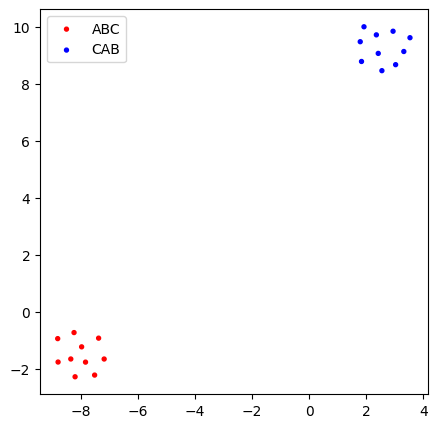

In [12]:
reducer = UMAP(metric = 'precomputed')
embedding = reducer.fit_transform(switch_score_mat + switch_score_mat.T)
plt.figure(figsize=(5,5)) 
plt.scatter(embedding[:10,0] ,embedding[:10,1], color = ['red']*10 , s = 8 )
plt.scatter(embedding[10:,0] ,embedding[10:,1], color = ['blue']*10 , s = 8 )
plt.legend(["ABC","CAB" ])

We note that the methods in `switch_probabilities` work well on this dataset because the proteins are very morphologically similar in the GW metric. For proteins with greater variation, these techniques do not always work so well.

In [13]:
np.max(A.get_GW_dmat())

np.float64(1.0828375132607377)